In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Google Colab/DOC')
print(os.getcwd())

/content/drive/My Drive/Google Colab/DOC


In [3]:
import sys
import numpy as np
import pandas as pd
import random, yaml
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from random import seed, sample
%matplotlib inline

import torch.nn as nn
import torch, torchvision
import torch.optim as optim
import torch.utils.data as data
from collections import OrderedDict
from torchvision import datasets, models, transforms

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

from docloss import DocLoss

In [4]:
class MyModel(nn.Module):
    def __init__(self, model):
        super(MyModel,self).__init__()
        self.base = model
    
    def forward(self, input_ref, input_tar):
        return self.base(input_ref), self.base(input_tar)

In [5]:
def load_model(classes_num):
    use_trained = True
    net = models.mobilenet_v2(pretrained=use_trained)

    net.classifier = nn.Linear(in_features=1280, out_features=classes_num)    

    params_to_update = []

    update_param_flag = False
    for name, param in net.named_parameters():
        if name == 'features.15.conv.0.0.weight':
            update_param_flag = True
        
        if update_param_flag:
            param.requires_grad = True
            params_to_update.append(param)

        else:
            param.requires_grad = False

    optimizer = optim.SGD([
        {'params': params_to_update, 'lr': 5e-5},
    ], weight_decay=5e-5)

    net = MyModel(net)

    return net, optimizer

In [15]:
def dataload():
    train_dataset = datasets.FashionMNIST(root='./', train=True, download=True)
    val_dataset = datasets.FashionMNIST(root='./', train=False, download=True)
    # 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 7:'Sneaker', 'Bag', 9:'Ankle boot'
    train_ref = []
    train_tar = []
    val_nor = []
    val_abn = []

    for (im, la) in train_dataset:
        if la == 9: # ブーツ
            continue
        elif la == 7: # スニーカー
            train_tar.append((im, la))
        elif len(train_ref) < 6000:
            train_ref.append((im, la))

    print(f'train_tarの数:{len(train_tar)}')
    print(f'train_refの数:{len(train_ref)}')

    for (im, la) in val_dataset:
        if la == 9:
            val_abn.append((im,la))
        elif la == 7:
            val_nor.append((im, la))

    print(f'val_norの数:{len(val_nor)}')
    print(f'val_abnの数:{len(val_abn)}')

    return train_ref, train_tar, val_nor, val_abn

In [7]:
class LoadDataset(data.Dataset):    
    def __init__(self, dataset_list, transform=None):
        self.dataset_list = dataset_list
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset_list)

    def __getitem__(self, index):
        img = self.dataset_list[index][0].convert('RGB')
        img_transformed = self.transform(img)
        label = self.dataset_list[index][1]
        return img_transformed, label

In [8]:
def make_dataloader():
    size = 224
    batch_size = 64
    transform = transforms.Compose([
                    transforms.Resize(size),
                    transforms.ToTensor()])
    
    train_ref, train_tar, val_nor, val_abn = dataload()

    train_ref_dataset = LoadDataset(train_ref, transform)
    train_tar_dataset = LoadDataset(train_tar, transform)
    val_dataset = LoadDataset(val_nor + val_abn, transform)

    train_ref_dataloader = data.DataLoader(dataset=train_ref_dataset, batch_size=batch_size,shuffle=True)
    train_tar_dataloader = data.DataLoader(dataset=train_tar_dataset, batch_size=batch_size,shuffle=True)
    val_dataloader = data.DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False)
    
    return train_ref_dataloader,train_tar_dataloader,val_dataloader

In [11]:
def train(net, train_ref_dataloader, train_tar_dataloader, optimizer, epochs):
    # GPUが使えるかを確認
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net) # make parallel
       
        # ネットワークがある程度固定であれば、高速化させる
        torch.backends.cudnn.benchmark = True

    cross = nn.CrossEntropyLoss()
    batchsize = 64
    classes_num = 10
    doc = DocLoss(batchsize=batchsize,classes_num=classes_num)
    LAMBDA = 0.1
    loss_c_li, loss_d_li = [], []
    # epochのループ
    for epoch in range(epochs):
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, epochs))
        epoch_loss_c = 0.0
        epoch_loss_d = 0.0

        net.train()
        for (in_ref, la_ref), (in_tar, _) in tqdm(zip(train_ref_dataloader, train_tar_dataloader)):
            # GPUが使えるならGPUにデータを送る
            in_ref = in_ref.to(device)
            la_ref = la_ref.to(device)

            in_tar = in_tar.to(device)

            # optimizerを初期化
            optimizer.zero_grad()

            # 順伝搬（forward）計算
            with torch.set_grad_enabled(True):
                out_ref, out_tar = net(in_ref, in_tar)

                loss_d = cross(out_ref, la_ref)
                loss_c = doc(out_tar)

                total_loss = loss_d + LAMBDA * loss_c
                total_loss.backward()
                optimizer.step()
                print('*************', in_ref.size(0))
                epoch_loss_d += loss_d.item() * in_ref.size(0)
                epoch_loss_c += loss_c.item() * in_tar.size(0)

        epoch_loss_d = epoch_loss_d / len(train_ref_dataloader.dataset)
        epoch_loss_c = epoch_loss_c / len(train_tar_dataloader.dataset)
        loss_c_li.append(epoch_loss_c)
        loss_d_li.append(epoch_loss_d)
        print(f'train\nloss_d:{epoch_loss_d}\nloss_c:{epoch_loss_c}')

    save_path = './doc_weights.pth'
    torch.save(net.state_dict(), save_path)
    
    return loss_c_li, loss_d_li

In [12]:
def plot_history_loss(loss_d_li, loss_c_li):
    plt.plot(loss_d_li,label="Descriptive loss")
    plt.plot(loss_c_li, label='Compact loss')
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

In [13]:
def main():
    classes_num = 10
    epochs = 100

    net, optimizer = load_model(classes_num)

    train_ref_dataloader,train_tar_dataloader, val_dataloader = make_dataloader()

    loss_c_li, loss_d_li = train(net, train_ref_dataloader, train_tar_dataloader, optimizer, epochs)

    plot_history_loss(loss_d_li, loss_c_li)

In [16]:
if __name__ == '__main__':
    # 乱数のシードを設定
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
    

    main()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


train_tarの数:6000
train_refの数:6000
val_norの数:1000
val_abnの数:1000
使用デバイス： cuda
-------------
Epoch 1/100


0it [00:00, ?it/s]

************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64
************* 64


KeyboardInterrupt: ignored

# 可視化

## 入力画像をそのまま可視化

In [ ]:
def fashion_mnist_tsne():
    _, _, val_nor, val_abn = dataload()
    test_batch = [np.asarray(im) for (im, _) in val_nor]
    target = [0] * len(test_batch)
    test_batch += [np.asarray(im) for (im, _) in val_abn]
    target += [1] * (len(test_batch) - len(target))

    test_batch = np.asarray(test_batch).reshape(-1,28*28)
    target = np.asarray(target)

    latent_vecs = torch.Tensor(test_batch)
    target = torch.Tensor(target) 

    print(latent_vecs.shape, target.shape)
    latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    
    plt.scatter(latent_vecs_reduced[:1000, 0], latent_vecs_reduced[:1000, 1],c='blue', cmap='jet', alpha=0.5)
    plt.show()
    
    plt.scatter(latent_vecs_reduced[1000:, 0], latent_vecs_reduced[1000:, 1],c='red', cmap='jet', alpha=0.5)
    plt.show()

    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],c=target, cmap='jet', alpha=0.5)
    plt.show()

train_tarの数:6000
train_refの数:6000
val_norの数:1000
val_abnの数:1000
torch.Size([2000, 784]) torch.Size([2000])


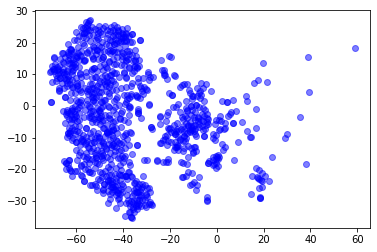

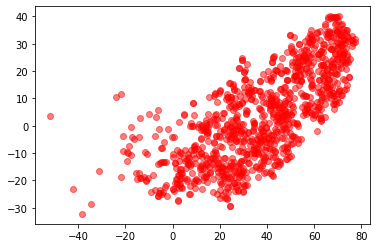

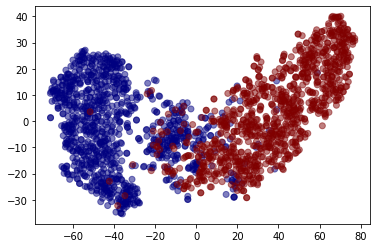

In [ ]:
if __name__ == "__main__":
    fashion_mnist_tsne()

## modelを通して可視化

In [ ]:
def load_trained_model():
    net = models.mobilenet_v2(False)

    classes_num=10
    net.classifier = nn.Linear(in_features=1280, out_features=classes_num)
    net_weights = torch.load('./doc_weights.pth', map_location={'cuda': 'cpu'})
    new_state_dict = OrderedDict()

    for name, param in net_weights.items():
        name = name[12:]
        new_state_dict[name]=param
    net.load_state_dict(new_state_dict)
    net = nn.Sequential(*(list(net.children())[:-1]))

    return net

In [ ]:
def plot_sklearn_tsne():
    net = load_trained_model()
    net.eval()

    _, _,val_dataloader = make_dataloader()

    avgpool = nn.AvgPool2d(7)
    for i, (im, la) in enumerate(val_dataloader):
        outputs = net(im)
        outputs = avgpool(outputs)
        if i == 0:
            latent_vecs = outputs.cpu().detach().numpy()
            target = (la == 9).numpy()
        else:
            latent_vecs = np.vstack((latent_vecs, outputs.cpu().detach().numpy()))
            target = np.hstack((target, (la == 9).numpy()))

    latent_vecs = latent_vecs.reshape((len(latent_vecs), -1))
    print(latent_vecs.shape, target.shape)
    latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    
    plt.scatter(latent_vecs_reduced[:1000, 0], latent_vecs_reduced[:1000, 1],c='blue', cmap='jet', alpha=0.5)
    plt.show()
    
    plt.scatter(latent_vecs_reduced[1000:, 0], latent_vecs_reduced[1000:, 1],c='red', cmap='jet', alpha=0.5)
    plt.show()
    
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],c=target, cmap='jet', alpha=0.5)
    plt.show()

train_tarの数:6000
train_refの数:6000
val_norの数:1000
val_abnの数:1000
(2000, 1280) (2000,)


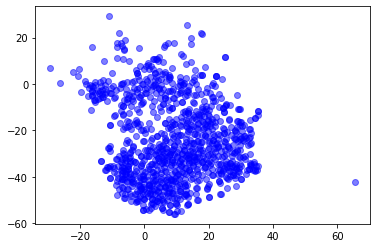

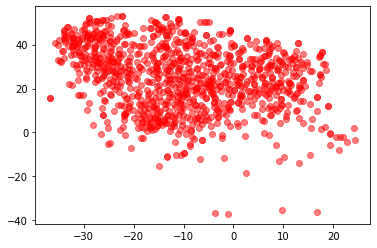

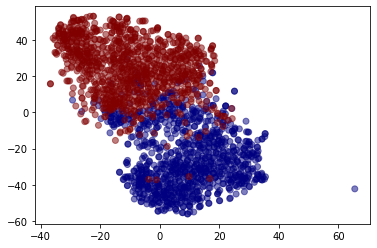

In [ ]:
if __name__ == "__main__":
    plot_sklearn_tsne()

#異常検知精度

In [ ]:
def test():
    net = load_trained_model()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net) # make parallel
       
        # ネットワークがある程度固定であれば、高速化させる
        torch.backends.cudnn.benchmark = True

    # 推論モード
    net.eval()

    _, train_tar_dataloader, val_dataloader = make_dataloader()
    
    avgpool = nn.AvgPool2d(7)
    
    for i, (im, _) in enumerate(train_tar_dataloader):
        out = net(im)
        out = avgpool(out)
        if i == 0:
            train = out.cpu().detach().numpy()
        else:
            train = np.vstack((train, out.cpu().detach().numpy()))
    
    for i, (im, la) in enumerate(val_dataloader):
        out = net(im)
        out = avgpool(out)
        if i == 0:
            test = out.cpu().detach().numpy()
            trues = (la == 9).cpu().detach().numpy()
        else:
            test = np.vstack((test, out.cpu().detach().numpy()))
            trues = np.hstack((trues, (la == 9).numpy())) # 9は異常 == True(1)

    # 一次元に変換
    train = train.reshape((len(train),-1))
    test = test.reshape((len(test),-1))
    print(train.shape)
    print(test.shape)
    print(trues.shape)
    
    #0-1に変換
    ms = MinMaxScaler()
    train = ms.fit_transform(train)
    test = ms.transform(test)

    # fit the model
    clf = LocalOutlierFactor(n_neighbors=5)
    clf.fit(train)

    # 異常スコア
    Z = -clf._decision_function(test)

    # FPR, TPR(, しきい値) を算出
    fpr, tpr, _ = metrics.roc_curve(trues, Z)

    # AUC
    auc = metrics.auc(fpr, tpr)

    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

使用デバイス： cuda
train_tarの数:6000
train_refの数:6000
val_norの数:1000
val_abnの数:1000
(6000, 1280)
(2000, 1280)
(2000,)


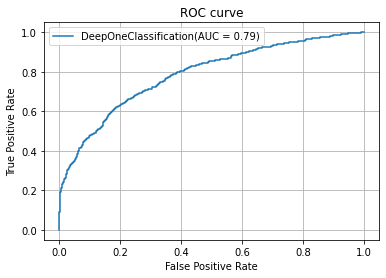

In [ ]:
if __name__ == "__main__":
    test()